# Loading Packages & Initialization

In [2]:
folder.path = "C:/Users/paslanpatir/Desktop/TEZ_v2/"
source(paste0(folder.path,"pickleware/pickleware/TezV2_SetupCode.r"))

Is_Headless <- 1
nl.model <- "Segregation_Dummy"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
folder.path = "C:/Users/paslanpatir/Desktop/TEZ_v2/"

model.path <- paste0(folder.path, nl.model, ".nlogo")

if (Is_Headless == 0) {
    NLStart(nl.path, gui = TRUE, nl.jarname = "netlogo-6.0.4.jar")
    NLLoadModel(model.path)
} else {
    NLStart(nl.path, gui = FALSE, nl.jarname = "netlogo-6.0.4.jar", nl.obj = nl.model)
    NLLoadModel(model.path, nl.obj = nl.model)
}

In [3]:
model.type = ifelse(nl.model == "Segregation", "basic", "dummy")
# the path of data folder
data.path = paste0(folder.path,"data/")
# the path for outputs to be record
output.folder = paste0("outputs_DynamicElim_PoolUpd_",model.type,"_",Sys.Date())
dir.create(file.path(folder.path, output.folder), showWarnings = FALSE)

outputs.path = paste0(folder.path,output.folder,"/")

# Read Me File to keep info about the output folder
ReadMe = paste0(outputs.path,"ReadMe_",model.type,".txt")

# Model Parameters & Functions

## Set model parameters

In [4]:
#### Model Parameters ####
## Set model parameters Number of replications for each instance
nofrep = 10 ###########################################################################

# order feature names according to their definition order in run_model
if (model.type == "basic") {
    feature_names = c("density", "%-similar-wanted")
} else if (model.type == "dummy") {
    feature_names = c("density", "%-similar-wanted", "budget-multiplier-dummy", "density-multiplier-dummy", 
        "noise-dummy", "tick-limit")
}  
# 
output_name = c("percent-similar")

# Number of input parameters of the agent-based model
nofparams = length(feature_names)

# set RF parameters
ntree = 300
mtry = 2
nperm = 5

## Set user parameters

In [5]:
#### User parameters ####
error_type = "RMSE"  # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "coefvar"  #, 'range' 

# Number of iterations
iteration_budget = 11
metarep = c(1:5)

# Number of instances
unlabeled_ins = 100
test_ins = c(100)
train_ins_oneshot = 100
train_ins_Ad = 50

# Set selection parameters
selected_ins = 5  #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1  # number of variables eliminated in each step

seed.focus = c(0,4)

## !!!
unlabeled.type = "refresh and dynamic Elim & FeaturElimInduced"
sample.type = ""

log_entry()

# Test Set

In [6]:
#### Test Sets ####
for( t in test_ins){
    test_set.name= paste0(data.path,"test_set","_",model.type,"_",t,".csv")
    test_set <- fread(test_set.name)  
    
    assign(paste0("test_set_",t),test_set)
}

# Adaptive Training Set

In [7]:
adaptive_initial_data = upload_training_set(model.type,seed.focus,train_ins_Ad)

## Adaptive & Feature Elimination Train & Test Metamodel

In [8]:
  ## unique to each seed and rep, updated iter by iter
get_importance_data = function(model,type,scaled,n){
    #n shows how many iterations' values will be evaluated (moving average n)
    iteration_imp = data.table(t(importance(model, type = type, scaled = scaled))) %>% melt()
    setnames(iteration_imp,"variable","feature")
    
    imp_history = if(nrow(importance_data) > 0){
        copy(importance_data[iter_no >= 1 & iter_no > (iter - n)])
    }else{
        data.table()
    }
          
    imp_history = rbind(imp_history, data.table(iter_no = iter
                                                ,iteration_imp
                                                ,cm_mean = as.numeric(NA)))
    imp_history[, cm_mean := mean(value),.(feature)]
    
    return(imp_history[iter_no == iter])
    
}

#importance_data = rbind(importance_data, get_importance_data(model,1,TRUE,3))

In [ ]:
#for (iter in 1:11){
#model = readRDS(paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/outputs/outputs_50_100/outputs_SampleRef_Dummy/Ad_coefvar/models_Ad_coefvar/model_Ad_coefvar_",iter,"_seed_0_rep_1_size_50.rds"))
#importance_data = rbind(importance_data, get_importance_data(model,1,TRUE,3))
#    }

In [9]:
# in each iteration the result of this function is checked
#importance data should hold historic data for an seed-rep combination through iterations
importance_partition = function(grid_partition, iteration_importance_data, column_name) {
    # name of the column which grid separation performed will be based on
    iteration_importance_data[, `:=`(grid_no, as.numeric(NA))]
    iteration_importance_data[get(column_name) < 0, `:=`(grid_no, 0)]
    
    grid = 0
    order = 0
    
    while (is.na(iteration_importance_data[which.max(iteration_importance_data[[column_name]])]$grid_no)) {
        order = order + 1
        
        grid_up = grid + grid_partition
        
        idx = which(iteration_importance_data[[column_name]] < grid_up & iteration_importance_data[[column_name]] > grid)       
        iteration_importance_data[idx, `:=`(grid_no, order)]        
        grid = copy(grid_up)       
    }
    iteration_importance_data[order(grid_no), `:=`(grid_order, .GRP), .(grid_no)]
    
    return(iteration_importance_data)
}

In [10]:
start_elimination = function(importance_data_partioned){
    #partitioned_importance_data
    importance_data_partioned = importance_data_partioned[order(iter_no)]
    importance_data_partioned[,prev_grid_order := shift(grid_order,1, type = "lag"),.(feature)]
    importance_data_partioned[,order_diff :=  grid_order - prev_grid_order ]

    elimination_start_iter = ifelse(nrow(importance_data_partioned[order_diff == 0,.N,.(iter_no)][N == length(feature_names)]) > 0,
                                   importance_data_partioned[order_diff == 0,.N,.(iter_no)][N == length(feature_names)]$iter_no,
                                   0)
    return(elimination_start_iter)
}
# returns the iteration number where the elimination starts

In [ ]:
#######
feature_ranges =data.table(  feature = feature_names
                           , min_range = c(10,10,1,0.01,0.00001,90)
                           , max_range = c(90,90,10,1,0.0001,110))

refresh_sample_pool_Elim <- function(selected.seed, columns_left = feature_names) {
    set.seed(selected.seed)
    
    
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = length(columns_left), dup = 5))
    setnames(unlabeled_pool, c(paste0("V",1:length(columns_left))), columns_left)
        
     
    for( c in 1:length(columns_left)){
      unlabeled_pool[[c]] = qunif(unlabeled_pool[[c]],feature_ranges[feature == colnames(unlabeled_pool)[c]]$min_range
                                                     ,feature_ranges[feature == colnames(unlabeled_pool)[c]]$max_range)
    }
    
    random_pool_all= data.table()
    eliminated_columns = setdiff(feature_names,columns_left)
    if(length(eliminated_columns) > 0){
        for( e in 1:length(eliminated_columns)){
            random_pool = data.table(runif(unlabeled_ins
                                    ,feature_ranges[feature == eliminated_columns[e]]$min_range
                                    ,feature_ranges[feature == eliminated_columns[e]]$max_range) )
            setnames(random_pool,eliminated_columns[e])
            
            random_pool_all= cbind(random_pool_all,random_pool)
        }
    
   unlabeled_pool = cbind(unlabeled_pool,random_pool_all)     
}
    
return(unlabeled_pool)       
}

In [58]:
#### Adaptive Feature Selection Training ####

# Record model performances
performance_table = data.table(iter = numeric(),seed = numeric(),rep = numeric(),size = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
# Record obb_error table
obb_error = data.table(iter = numeric() ,obb_error = numeric(),seed = numeric(),rep = numeric())

## initialize variables
predictedLabels_all = data.table()
train_candidates_all = data.table()
training_set_Ad_final = data.table()
importance_table_AdFe_All = data.table()
iteration_history_AdFe = data.table()


# specify variables(columns) to be used initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0
    
importance_partition_column = "cm_mean" # or "value"
oob_decrease_multiplier = 1.1

grid_partition = 5

oob_decrease_table = data.table()

In [59]:
sample.type = paste0("AdFe_",selection_metric)
sample.folder = paste0(sample.type,"/")
dir.create(file.path(folder.path, output.folder,sample.folder), showWarnings = FALSE)

models.folder = paste0("models_",sample.type,"/")
dir.create(file.path(folder.path, output.folder,models.folder), showWarnings = FALSE)

PL.folder = paste0("PL_",sample.type,"/")
dir.create(file.path(folder.path, output.folder,PL.folder), showWarnings = FALSE)

for(i in seed.focus){

print(paste0("seed : ",i,"  Adaptive Sampling with Feature Selection section start time : ",Sys.time()))
    
for (r in metarep){ #replications
    set.seed(i + r)
        print(paste0("seed : ", i,"   rep : ", r, "  Adaptive Sampling with Feature Selection section start time : ", Sys.time()))
    
    training_set_Ad = copy(adaptive_initial_data[seed == i, .SD, .SDcols = -c("seed")])
    train_candidates_table = data.table()
        
    columns_left = feature_names # reset at the beginning of each iteration
    total_numof_eliminated_vars <- 0 # reset at the beginning of each iteration
    
    iteration_history = data.table("seed" = integer(),"rep" = integer(),"iter_no" = integer()
                                  ,"IsFeatureEliminated" = logical(), "IsDataSelected" = logical()
                                  ,"NumOfEliminated" = integer())

    importance_data = data.table()
    importance_data_partioned = data.table()
    elimination_start_iter = 0
    
    iter = 1
    while(iter <= iteration_budget){   
        print(iter)
    
        trainx = training_set_Ad[,.SD, .SDcols = columns_left]
        trainy = training_set_Ad$output
        
        # Train the model
        model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry, nperm = nperm)
        model_Sub.name = paste0("model_",sample.type,"_", iter, "_seed_", i, "_rep_",r)
        assign(model_Sub.name,model_Sub)
        model_Sub.path = paste0(outputs.path,models.folder, paste0(model_Sub.name,"_size_",train_ins_Ad, ".rds"))  # to save the model
        saveRDS(model_Sub, model_Sub.path)
        
        #to append
        obb_err = rbind( data.table(iter = numeric() ,obb_error = numeric(),seed = numeric(),rep = numeric())
                        ,data.table(iter, obb_error_func(model_Sub), i, r), use.names = FALSE)            
        fwrite(obb_err,paste0(outputs.path,sample.folder,model.type,"_Append_","obb_error_",sample.type,".csv") ,append = TRUE)
        ##                
        obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub),i,r),use.names=FALSE)
        
        # test the model on test set
        predictedLabels_Comb = data.table()
        for (t in test_ins) {
            test_set = get(paste0("test_set_", t))
            
            test_predictions_Sub = get_test_predictions(model_Sub, test_set,error_type)
            predictedLabels_Sub = test_predictions_Sub[[1]]
            setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))

            fwrite(predictedLabels_Sub
                   ,paste0(outputs.path,PL.folder,model.type
                           ,"_","predictedLabels.",sample.type,"_seed_",i,"_iter_",iter,"_rep_",r,"_size_",t,".csv") ) 

            predictedLabels_Comb = rbind(predictedLabels_Comb, data.table(size = t,predictedLabels_Sub))   
             
             # Keep test set error records
                #to append
                perf_table = rbind(data.table(iter = numeric(),seed = numeric(),rep = numeric(),size = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
                                  ,data.table(iter, i, r, t, test_predictions_Sub[[2]]),use.names = FALSE )
                fwrite(perf_table,paste0(outputs.path,sample.folder,model.type,"_Append_","performance_table_",sample.type,".csv"),append = TRUE )    
                ##
                performance_table = rbind(performance_table, data.table(iter, i, r, t, test_predictions_Sub[[2]]),use.names = FALSE)
                        }
        if(iter == 1){
            predictedLabels_table = copy(predictedLabels_Comb[,1:4])
        }
            
        predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Comb[,.SD ,.SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])

        write_importance.rf(i,r,iter,model_Sub,sample.type)#last one=sample_type
        
        if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached. 
            iteration_history= rbind(iteration_history,data.table(i,r,iter,0,0,0), use.names = FALSE)
            
            ### SAMPLE SELECTION ###
                ## sample selection from unlabeled data select candidates
                unlabeled_set <- refresh_sample_pool_Elim(i + r + iter, columns_left)
                train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
                
                # run ABM to find outputs of train candidates
                print(paste0("ABM train_candidate run start time : ",Sys.time()))
                train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
                print(paste0("ABM train_candidate run end time : ",Sys.time()))
                
                fwrite(data.table(train_candidates, "iter" = iter, "seed" = i, "rep" = r)
                       ,paste0(outputs.path,sample.folder,model.type,"_train_candidates_table_",sample.type,".csv"),append = TRUE )      
          
            
             ## add this part after elimination ##
             ## add labeled candidates to the train data
             #   training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
             #   
             #   # update iteration_history
             #    iteration_history[iter]$IsDataSelected= 1
            
            ### SAMPLE SELECTION ENDS ###
            
            
            ### FEATURE SELECTION CHECK ###
            if(elimination_start_iter == 0){
                
            importance_data = rbind(importance_data, get_importance_data(model_Sub,1,TRUE,3))
            importance_data_partioned = rbind(importance_data_partioned
                                             ,importance_partition(5,importance_data[iter_no == iter],importance_partition_column))
            elimination_start_iter = start_elimination(importance_data_partioned)
            }
            #feature selection can start in iter == elimination_start_iter
            #since importances settle down so far
            ### FEATURE SELECTION CHECK ENDS ###
            
        # calculate variable importances to be used

        if (iter == elimination_start_iter) {
            ranked_features = get_variable_importance(model_Sub)
            
            h = nrow(importance_data[iter_no == elimination_start_iter & value < 0]) # in order to eliminate negative importance
        
            obb_error_hist = obb_error[iter <= elimination_start_iter & seed == i & rep == r]
            obb_error_hist[,obb_decrease := shift(obb_error,1,type = "lag") - obb_error]
            min_expected_oob_decrease = max(max(obb_error_hist$obb_decrease, na.rm = TRUE),0)
            oob_decrease_table = rbind(oob_decrease_table
                                           ,data.table(seed = i, rep = r, iter = 0,oob_decrease = min_expected_oob_decrease))
        }
            
            ### FEATURE ELIMINATION PART I ###
            if(iter >= elimination_start_iter & elimination_start_iter != 0){
                # Assume as if feature(s) will be eliminated
                feature_elimination_result = feature_elimination(h, total_numof_eliminated_vars, ranked_features)
                planned_columns_left = feature_elimination_result[[1]]
                
                model_Sub_afterElim <- randomForest( x = training_set_Ad[,.SD, .SDcols = planned_columns_left]
                                                 ,y =  training_set_Ad$output
                                                 ,importance = TRUE, nperm = nperm
                                                 ,ntree = ntree, mtry = mtry)
                model_Sub_afterElim.name = paste0("model_afterElim_",sample.type,"_", iter, "_seed_", i, "_rep_",r)
                model_Sub_afterElim.path = paste0(outputs.path,models.folder, paste0(model_Sub_afterElim.name,"_size_",train_ins_Ad, ".rds"))  # to save the model
                saveRDS(model_Sub_afterElim, model_Sub_afterElim.path)
               
                oob_decrease = obb_err$obb_error - obb_error_func(model_Sub_afterElim)  
       
                fwrite(data.table(seed = i, rep = r, iter = iter,oob_decrease = oob_decrease)
                    ,paste0(outputs.path,sample.folder,model.type,"_oob_decrease_",sample.type,".csv"),append = TRUE )       
     
                oob_decrease_table = rbind(oob_decrease_table
                                           ,data.table(seed = i, rep = r, iter = iter,oob_decrease = oob_decrease))
                
                ### FEATURE SELECTION PART II ###
                if(oob_decrease > (min_expected_oob_decrease * oob_decrease_multiplier)){# then eliminate
                    columns_left = planned_columns_left
                    total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])
                    eliminated_columns = feature_elimination_result[[4]]  #   not necessary
                    numof_eliminated_vars = as.numeric(feature_elimination_result[3])  #   not necessary 
                    
                    # update iteration_history
                    iteration_history[iter]$IsFeatureEliminated= 1
                    iteration_history[iter]$NumOfEliminated= numof_eliminated_vars
                }
                      
            h = 1
            }
            
            ### FEATURE SELECTION ENDS ###
            
                # add labeled candidates to the train data
                training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
                
                # update iteration_history
                 iteration_history[iter]$IsDataSelected= 1
        }
         
        fwrite(iteration_history[iter],paste0(outputs.path,sample.folder,model.type,"_iteration_history_",sample.type,".csv"),append = TRUE )       
        iter = iter + 1
    }
    fwrite(data.table(training_set_Ad, "seed" = i,"rep" = r),paste0(outputs.path,sample.folder,model.type,"_FinalTrainData_",sample.type,".csv") ,append = TRUE)
    fwrite(data.table(predictedLabels_table, "seed" = i, "rep" = r),paste0(outputs.path,sample.folder,model.type,"_predictedLabels_table_",sample.type,".csv"),append = TRUE )                                       
    
    print(paste0("seed : ",i,"   rep : ", r,"  Adaptive Sampling with Feature Elimination section end time : ",Sys.time()))
}
    print(paste0("seed : ",i,"  Adaptive Sampling with Feature Elimination section end time : ",Sys.time()))
    #rm(training_set_Ad,predictedLabels_table,train_candidates_table)      
}

[1] "seed : 4  Adaptive Sampling with Feature Selection section start time : 2020-03-19 03:35:32"
[1] "seed : 4   rep : 2  Adaptive Sampling with Feature Selection section start time : 2020-03-19 03:35:32"
[1] 1
[1] "ABM train_candidate run start time : 2020-03-19 03:35:32"
[1] "ABM train_candidate run end time : 2020-03-19 03:35:45"
[1] 2
[1] "ABM train_candidate run start time : 2020-03-19 03:35:45"
[1] "ABM train_candidate run end time : 2020-03-19 03:35:53"
[1] 3
[1] "ABM train_candidate run start time : 2020-03-19 03:35:53"
[1] "ABM train_candidate run end time : 2020-03-19 03:36:02"
[1] 4
[1] "ABM train_candidate run start time : 2020-03-19 03:36:02"
[1] "ABM train_candidate run end time : 2020-03-19 03:36:11"
[1] 5
[1] "ABM train_candidate run start time : 2020-03-19 03:36:11"
[1] "ABM train_candidate run end time : 2020-03-19 03:36:22"
[1] 6
[1] "ABM train_candidate run start time : 2020-03-19 03:36:22"
[1] "ABM train_candidate run end time : 2020-03-19 03:36:25"
[1] 7
[1] "ABM

In [ ]:
# Final records
#FinalTrainData_AdFe = copy(training_set_Ad_final)
obb_error_AdFe = copy(obb_error)
performance_table_AdFe = copy(performance_table)
#predictedLabels_table_AdFe = copy(predictedLabels_all)
#train_candidates_table_AdFe  = copy(train_candidates_all)

In [ ]:
rm(training_set_Ad_final,obb_error,performance_table,predictedLabels_all,train_candidates_all)

In [ ]:
#fwrite(importance_table_AdFe_All,paste0(outputs.path,model.type,"_","importance_table_AdFe","_",selection_metric,".csv") )
#fwrite(FinalTrainData_AdFe,paste0(outputs.path,model.type,"_","FinalTrainData_AdFe","_",selection_metric,".csv") )
fwrite(performance_table_AdFe,paste0(outputs.path,sample.folder,model.type,"_","performance_table_AdFe","_",selection_metric,".csv") )
#fwrite(train_candidates_table_AdFe,paste0(outputs.path,model.type,"_","train_candidates_table_AdFe","_",selection_metric,".csv") )
#fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe","_",selection_metric,".csv") )
fwrite(obb_error_AdFe,paste0(outputs.path,sample.folder,model.type,"_","obb_error_AdFe","_",selection_metric,".csv") )
#fwrite(iteration_history_AdFe,paste0(outputs.path,model.type,"_","iteration_history_AdFe","_",selection_metric,".csv") )

In [ ]:
rm(importance_table_AdFe,FinalTrainData_AdFe,iteration_history_AdFe,performance_table_AdFe,train_candidates_table_AdFe,predictedLabels_table_AdFe,obb_error_AdFe)

# Kontrol

In [69]:
imp_ex = fread("C:/Users/paslanpatir/Desktop/TEZ_v2/outputs_dynamic_featsel_dummy_2020-03-19/dummy_importance_table_AdFe_coefvar.csv")


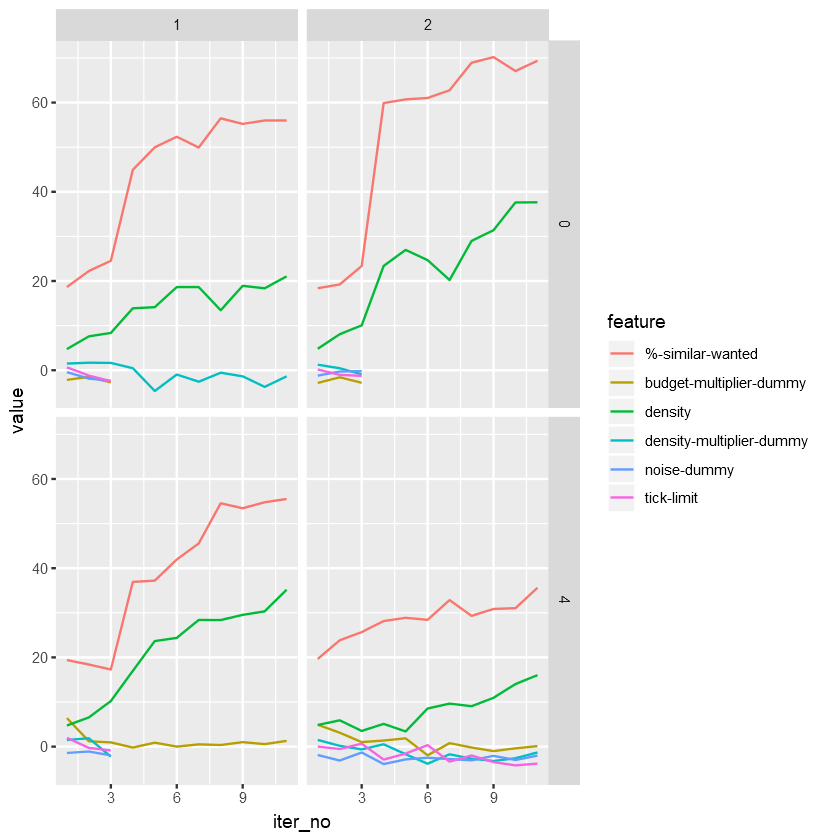

In [25]:
ggplot(imp_ex[scaled == "yes" & type ==1]
       , aes(x = iter_no, y = value, group = feature, col = feature)) + geom_line() + facet_grid(seed~rep)

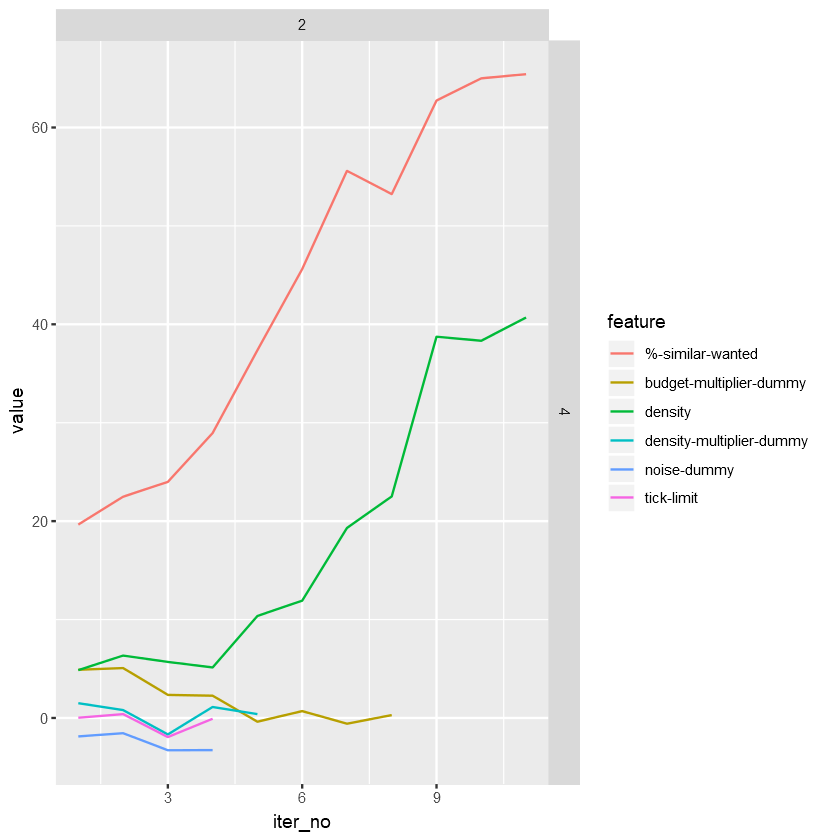

In [45]:
ggplot(imp_ex[scaled == "yes" & type ==1]
       , aes(x = iter_no, y = value, group = feature, col = feature)) + geom_line() + facet_grid(seed~rep)

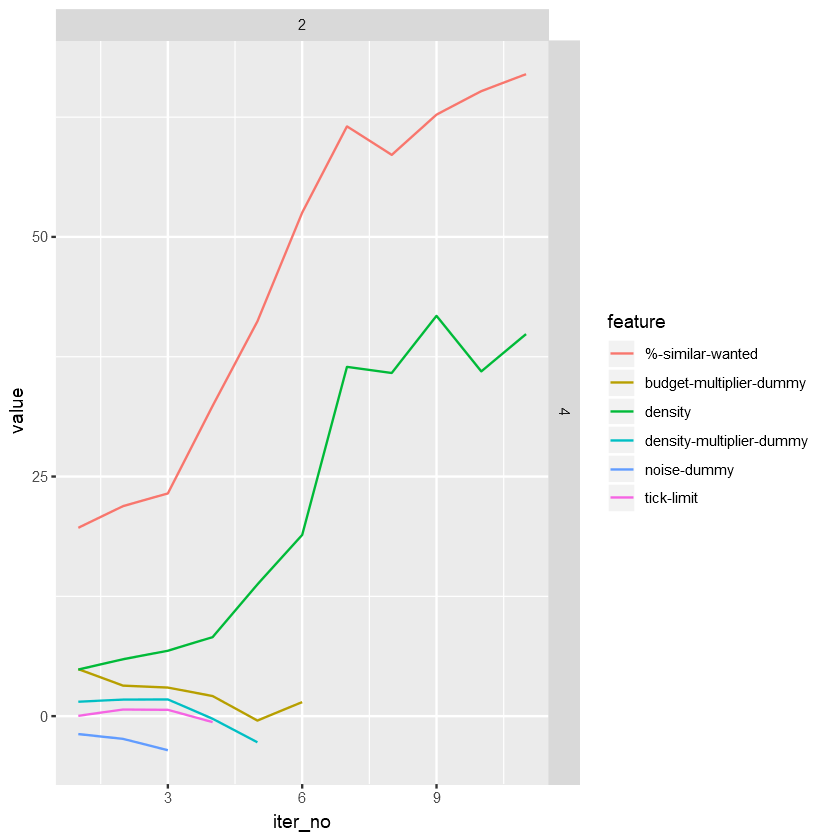

In [70]:
ggplot(imp_ex[scaled == "yes" & type ==1]
       , aes(x = iter_no, y = value, group = feature, col = feature)) + geom_line() + facet_grid(seed~rep)

In [72]:
oob_ta = fread("C:/Users/paslanpatir/Desktop/TEZ_v2/outputs_dynamic_featsel_dummy_2020-03-19/AdFe_coefvar/dummy_Append_obb_error_AdFe_coefvar.csv")


In [47]:
oob_ta

iter,obb_error,seed,rep
<int>,<dbl>,<int>,<int>
1,126.57379,4,2
2,113.34088,4,2
3,138.48435,4,2
4,128.25501,4,2
5,77.36979,4,2
6,52.45457,4,2
7,54.98929,4,2
8,56.99049,4,2
9,53.70506,4,2


In [73]:
oob_ta

iter,obb_error,seed,rep
<int>,<dbl>,<int>,<int>
1,126.57379,4,2
2,129.73625,4,2
3,132.96842,4,2
4,98.98717,4,2
5,86.11298,4,2
6,47.81669,4,2
7,33.13815,4,2
8,49.88630,4,2
9,44.74900,4,2


In [48]:
iteration_history

seed,rep,iter_no,IsFeatureEliminated,IsDataSelected
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,2,1,0,1
4,2,2,0,1
4,2,3,0,1
4,2,4,1,1
4,2,5,1,1
4,2,6,0,1
4,2,7,0,1
4,2,8,1,1
4,2,9,0,1


# Quit NL

In [ ]:
NLQuit(nl.obj = nl.model)
#NLQuit(all=TRUE)

In [ ]:
#grid_partition = 5
#data_all = data.table()
#
#for (s in c(1:9, 20)) {
#    for (r in 1:10) {
#        for (i in 1:10) {
#            data = copy(p[iter_no == i & seed == s & rep == r, .(seed, rep, iter_no, 
#                feature, value, cum_mn)])
#            
#            data[, `:=`(grid_no, c())]
#            data[cum_mn < 0, `:=`(grid_no, 0)]
#            
#            grid = 0
#            round = 0
#            while (is.na(data[which.max(data$cum_mn)]$grid_no)) {
#                round = round + 1
#                
#                grid_up = grid + grid_partition
#                
#                idx = which(data$cum_mn < grid_up & data$cum_mn >= grid)
#                data[idx, `:=`(grid_no, round)]
#                
#                grid = copy(grid_up)
#                
#            }
#            data[order(grid_no), `:=`(grid_order, .GRP), .(seed, rep, iter_no, grid_no)]
#            data_all = rbind(data_all, data)
#        }
#    }
#}